In [58]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import eigen

def openImage(imgPath):
    imgOriginal = Image.open(imgPath)
    im = np.array(imgOriginal)
    imgChannels = []
    bands = imgOriginal.getbands()
    imgAlpha = np.nan
    hasAlphaValue = False
    for band in bands:
        if band == 'A':
            imgAlpha = imgOriginal.getchannel("A")
            hasAlphaValue = True
        else:
            imgChannels.append(imgOriginal.getchannel(band))

    return imgChannels, imgAlpha, hasAlphaValue, imgOriginal, bands


def getSVDMatrices(m):
    mat = np.asarray(m).astype(float)
    r, c = np.shape(mat)
    if r < c:
        sqMat = mat @ mat.T
        AtransposexA = mat.T @ mat
    else :
        sqMat = mat.T @ mat
        AtransposexA = sqMat
    eigenValue = eigen.get_eigen_values(sqMat)
    eigenVectors = eigen.get_eigen_vectors(AtransposexA, eigenValue)

    sign = np.sign(eigenValue)
    s = np.sqrt(np.abs(eigenValue)) * sign
    u = []
    i = 0
    for eigenVector in eigenVectors:
        u.append((mat @ eigenVector.T) * 1/s[i])
        i += 1
    u = np.array(u).T

    vt = eigenVectors

    return u, s, vt

def compressSingleChannel(channel, r):
    u, s, vt = getSVDMatrices(channel)
    s = np.diag(s)
    compressed = u[:,:r] @ s[0:r, :r] @ vt[:r, :]
    return np.clip(compressed, 0, 255).astype('uint8')

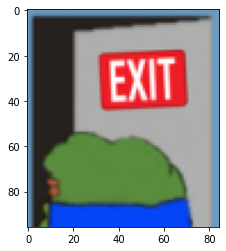

In [59]:
channels, alpha, hasAlpha, original, bands = openImage("pepeexit.png")
mean = np.mean(original, -1)
#plt.figure(figsize=(16, 9))
plt.imshow(original)

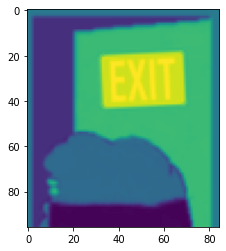

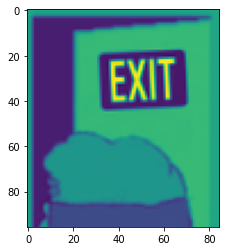

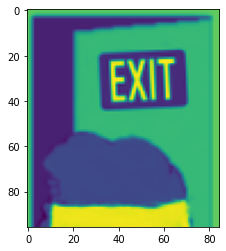

In [60]:
for channel in channels:
    #plt.figure(figsize=(16, 9))
    img = plt.imshow(channel)
    plt.show()

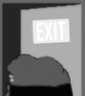

In [50]:
channels[0]

In [51]:
compressSingleChannel(channels[1], 30)

array([[156, 156, 156, ..., 156, 157, 157],
       [155, 154, 153, ..., 155, 156, 156],
       [155, 152, 145, ..., 155, 155, 155],
       ...,
       [153, 135,  79, ..., 157, 157, 157],
       [152, 135,  82, ..., 156, 156, 156],
       [151, 135,  86, ..., 155, 155, 155]], dtype=uint8)

r = 8


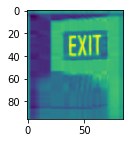

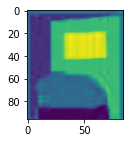

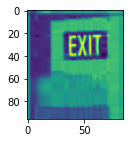

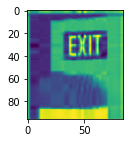

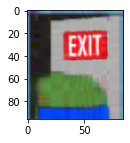

r = 25


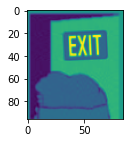

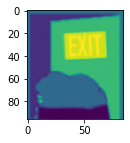

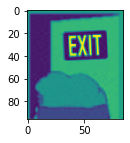

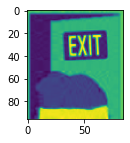

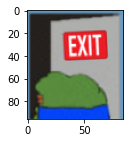

r = 50


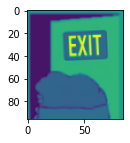

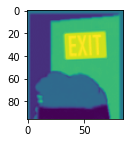

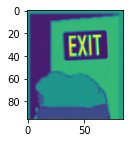

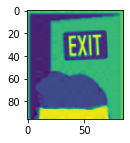

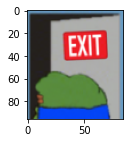

In [61]:
rank = np.linalg.matrix_rank(channels[0])
r10p = int(0.10 * rank)
r20p = int(0.20 * rank)
r30p = int(0.30 * rank)
r50p = int(0.50 * rank)
r60p = int(0.60 * rank)
r75p = int(0.75 * rank)
r80p = int(0.80 * rank)


for r in (r10p, r30p, r60p):
    print(f"r = {r}")

    compressedMean = compressSingleChannel(mean, r)

    compressedChannels = []
    for channel in channels:
        compressedChannels.append(compressSingleChannel(channel, r))


    compressedImageChannels = []
    for compressedChannel in compressedChannels:
        compressedImageChannels.append(Image.fromarray(compressedChannel, mode=None))

    if hasAlpha:
        compressedImageChannels.append(alpha)

    
    newImage = Image.merge(''.join(bands), tuple(compressedImageChannels))
    newImage.save("pepeexitcompressed"+str(r)+".png")

    plt.figure(figsize=(2, 2))
    img = plt.imshow(compressedMean)
    plt.show()  

    for compressedChannel in compressedChannels:
        plt.figure(figsize=(2, 2))
        img = plt.imshow(compressedChannel)
        plt.show()

    plt.figure(figsize=(2, 2))
    img = plt.imshow(newImage)
    plt.show()